# Modelo con datos aumentados

# Carga de datos

In [1]:
import pandas as pd
import numpy as np

# ===========================
# 1 Cargar y preparar datos
# ===========================
df = pd.read_csv("../data/aptos_bogota_enriched.csv")

# Renombrar columnas calculadas
df = df.drop("estrato", axis=1).rename(columns={
    "estrato_calculado": "estrato",
    "barrio_calculado": "barrio",
    "upz_calculada": "upz"
})

# Eliminar filas sin barrio (necesario para imputar)
df = df[~df['barrio'].isnull()].reset_index(drop=True)

print(f"Registros después de limpieza: {len(df)}")

# ===========================
# 2 Imputación jerárquica
# ===========================
def imputar_por_barrio(df, columna, metodo='media'):
    if metodo == 'media':
        imputacion = df.groupby('barrio')[columna].transform('mean')
    elif metodo == 'moda':
        imputacion = df.groupby('barrio')[columna].transform(
            lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0]
        )
    df[columna] = df[columna].fillna(imputacion)
    return df

# Variables a imputar
for col, metodo in [
    ('administracion', 'media'),
    ('estado', 'moda'),
    ('upz', 'moda'),
    ('catastral', 'media'),
    ('comercial', 'media'),
    ('antiguedad', 'moda')
]:
    if col in df.columns:
        df = imputar_por_barrio(df, col, metodo)

print("Imputación por barrio completada.")

# ===========================
# 3 Transformación logarítmica
# ===========================
df['precio_venta_log'] = np.log1p(df['precio_venta'])
df['area_log'] = np.log1p(df['area'])

# Confirmación de variables
print("\nColumnas transformadas añadidas:")
print(['precio_venta_log', 'area_log'])

df.head()


Registros después de limpieza: 27214
Imputación por barrio completada.

Columnas transformadas añadidas:
['precio_venta_log', 'area_log']


,precio_venta,area,habitaciones,banos,administracion,parqueaderos,sector,antiguedad,latitud,longitud,...,parks_and_recreation_2000,infrastructure_services_2000,cultural_amenities_2000,catastral,comercial,upz,barrio,localidad_calculada,precio_venta_log,area_log
0,339000000.0,76.0,3.0,2.0,300000.0,1.0,BRITALIA,ENTRE 10 Y 20 ANOS,4.746592,-74.057571,...,35,165,7,3.227303e+06,3.848904e+06,USAQUEN,SANTA ANA OCCIDENTAL,USAQUEN,19.641511,4.343805
1,440898168.0,54.0,3.0,2.0,305000.0,0.0,LA SABANA,ENTRE 0 Y 5 ANOS,4.607378,-74.082648,...,89,86,1,1.718168e+06,2.144399e+06,EL PRADO,EL PLAN,SUBA,19.904324,4.007333
2,158000000.0,43.0,2.0,2.0,106600.0,0.0,TIBABUYES,ENTRE 10 Y 20 ANOS,4.740109,-74.113675,...,144,85,1,1.627592e+06,2.322134e+06,EL PRADO,MAZUREN,SUBA,18.878106,3.784190
3,222800000.0,48.0,3.0,2.0,151000.0,0.0,VERBENAL,MAS DE 20 ANOS,4.763900,-74.025280,...,40,178,6,3.550046e+06,4.278709e+06,SANTA BARBARA,MOLINOS NORTE,USAQUEN,19.221785,3.891820
4,128900000.0,47.0,2.0,1.0,86500.0,0.0,TINTAL SUR,ENTRE 10 Y 20 ANOS,4.632698,-74.198111,...,39,190,20,3.340397e+06,4.172320e+06,EL REFUGIO,LOS ROSALES,CHAPINERO,18.674547,3.871201


In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# ===========================
# 4 Definir target y features
# ===========================
target = "precio_venta_log"

# Columnas que no se usarán como predictores
ignore_cols = [
    "precio_venta", "precio_venta_log", "sector",
    "localidad_calculada", "area_log"
]

# Variables predictoras
features = [col for col in df.columns if col not in ignore_cols]

X = df[features].copy()
y = df[target].copy()

# ===========================
# 5 Clasificar variables
# ===========================
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "bool"]).columns.tolist()

print(f"Variables numéricas: {len(numeric_features)}")
print(f"Variables categóricas: {len(categorical_features)}")

# ===========================
# 6 Preprocesamiento
# ===========================
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ],
    remainder="drop"
)

print("Preprocesamiento configurado correctamente")


Variables numéricas: 55
Variables categóricas: 4
Preprocesamiento configurado correctamente


In [3]:
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import pandas as pd
import numpy as np

# ===========================
# 7 Definir modelos
# ===========================
modelos = {
    "LinearRegression": LinearRegression(),
    "Lasso": Lasso(alpha=0.1, max_iter=10000),
    "Ridge": Ridge(alpha=1.0),
    "RandomForest": RandomForestRegressor(
        n_estimators=200, max_depth=None, random_state=42, n_jobs=-1),
    "SVR": SVR(kernel="rbf", C=10, epsilon=0.2),
    "XGBoost": XGBRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1),
    "LightGBM": LGBMRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=-1,
        subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1)
}

# ===========================
# 8 Configurar validación cruzada
# ===========================
kf = KFold(n_splits=10, shuffle=True, random_state=42)
scoring = {
    "RMSE": make_scorer(root_mean_squared_error, greater_is_better=False),
    "MAE": make_scorer(mean_absolute_error, greater_is_better=False),
    "R2": make_scorer(r2_score)
}

resultados = []

# ===========================
# 9 Evaluar cada modelo
# ===========================
for nombre, modelo in modelos.items():
    pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", modelo)])
    print("Evaluando modelo: ", nombre)
    cv_result = cross_validate(
        pipeline, X, y, cv=kf, scoring=scoring, n_jobs=-1, return_train_score=False
    )
    resultados.append({
        "Modelo": nombre,
        "RMSE medio": -np.mean(cv_result["test_RMSE"]),
        "RMSE std": np.std(cv_result["test_RMSE"]),
        "MAE medio": -np.mean(cv_result["test_MAE"]),
        "R² medio": np.mean(cv_result["test_R2"])
    })

# ===========================
# 10 Mostrar resultados ordenados
# ===========================
resultados_df = pd.DataFrame(resultados).sort_values(by="RMSE medio")
print(resultados_df.round(3))


Evaluando modelo:  LinearRegression
Evaluando modelo:  Lasso
Evaluando modelo:  Ridge
Evaluando modelo:  RandomForest
Evaluando modelo:  SVR
Evaluando modelo:  XGBoost
Evaluando modelo:  LightGBM
             Modelo  RMSE medio  RMSE std  MAE medio  R² medio
6          LightGBM       0.170     0.005      0.126     0.956
5           XGBoost       0.170     0.005      0.126     0.956
3      RandomForest       0.178     0.004      0.128     0.952
4               SVR       0.241     0.006      0.182     0.911
2             Ridge       0.279     0.008      0.212     0.881
0  LinearRegression       0.280     0.009      0.212     0.880
1             Lasso       0.337     0.007      0.263     0.827


Los resultados de la validación cruzada evidencian diferencias claras en el desempeño de los distintos algoritmos evaluados sobre el conjunto de datos enriquecido. Los modelos basados en árboles de decisión con técnicas de ensamble (XGBoost, LightGBM y Random Forest) superaron ampliamente a los modelos lineales y de soporte vectorial.

Tanto XGBoost como LightGBM obtuvieron un RMSE promedio de 0.17 (en escala logarítmica), equivalente a un error relativo aproximado del 18 % sobre el precio real, y un coeficiente de determinación R² de 0.956, lo que indica una capacidad explicativa muy alta. En comparación, los modelos lineales (Ridge, Lasso y Regresión Lineal) alcanzaron R² entre 0.88 y 0.88, mientras que el SVR presentó un rendimiento intermedio (R² ≈ 0.91).

Estos resultados confirman que los modelos no lineales y con capacidad de capturar interacciones complejas entre las variables —en especial las derivadas del enriquecimiento geoespacial— son más adecuados para el problema de estimación de precios inmobiliarios. En adelante, XGBoost se selecciona como modelo base enriquecido para la optimización e interpretación detallada.

## Búsqueda de mejores hiperparámetros

In [4]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import time

# ===========================
# 1️⃣ Definir espacio de búsqueda
# ===========================

# Espacio para XGBoost
xgb_param_dist = {
    "model__n_estimators": randint(200, 800),
    "model__max_depth": randint(3, 10),
    "model__learning_rate": uniform(0.01, 0.1),
    "model__subsample": uniform(0.7, 0.3),
    "model__colsample_bytree": uniform(0.7, 0.3)
}

# Espacio para LightGBM
lgbm_param_dist = {
    "model__n_estimators": randint(200, 800),
    "model__max_depth": randint(3, 10),
    "model__learning_rate": uniform(0.01, 0.1),
    "model__subsample": uniform(0.7, 0.3),
    "model__colsample_bytree": uniform(0.7, 0.3)
}

param_spaces = {
    "XGBoost": xgb_param_dist,
    "LightGBM": lgbm_param_dist
}

best_results = {}

# ===========================
# 2️⃣ Búsqueda aleatoria
# ===========================
for nombre_modelo, modelo in [("XGBoost", XGBRegressor(random_state=42)), 
                              ("LightGBM", LGBMRegressor(random_state=42))]:

    pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", modelo)])
    param_dist = param_spaces[nombre_modelo]

    search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_dist,
        n_iter=25,
        scoring="neg_root_mean_squared_error",
        cv=5,
        random_state=42,
        n_jobs=-1,
        verbose=2
    )

    print(f"\nBuscando mejores parámetros para {nombre_modelo}...")
    inicio = time.time()
    search.fit(X, y)
    duracion = time.time() - inicio

    print(f"Mejor RMSE ({nombre_modelo}): {-search.best_score_:.4f}")
    print(f"Mejores parámetros: {search.best_params_}")
    print(f"Duración: {duracion/60:.1f} minutos")

    best_results[nombre_modelo] = {
        "best_rmse": -search.best_score_,
        "best_params": search.best_params_,
        "search_time_min": round(duracion / 60, 2)
    }

# ===========================
# 3️⃣ Mostrar resumen
# ===========================
results_df = pd.DataFrame(best_results).T
print("\nResultados de optimización:")
print(results_df)



Buscando mejores parámetros para XGBoost...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Mejor RMSE (XGBoost): 0.1710
Mejores parámetros: {'model__colsample_bytree': np.float64(0.7076257380232285), 'model__learning_rate': np.float64(0.020789142699330444), 'model__max_depth': 9, 'model__n_estimators': 440, 'model__subsample': np.float64(0.794306794322898)}
Duración: 7.8 minutos

Buscando mejores parámetros para LightGBM...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5870
[LightGBM] [Info] Number of data points in the train set: 27214, number of used features: 347
[LightGBM] [Info] Start training from score 20.391700
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Tras la búsqueda de hiperparámetros mediante validación cruzada aleatoria (5 pliegues, 25 combinaciones por modelo), los resultados mostraron que XGBoost mantiene el mejor desempeño general, con un RMSE promedio de 0.171 y un R² cercano a 0.956, seguido de LightGBM con un RMSE de 0.174.
El ajuste de parámetros permitió validar la estabilidad del modelo: las mejoras respecto a la configuración inicial fueron marginales (<1%), lo que indica que el modelo ya se encontraba bien calibrado desde la etapa previa.

Los parámetros óptimos encontrados para XGBoost fueron:

n_estimators = 440

max_depth = 9

learning_rate ≈ 0.02

subsample ≈ 0.79

colsample_bytree ≈ 0.71

El tiempo total de búsqueda fue de aproximadamente 8 minutos, lo que demuestra un equilibrio adecuado entre precisión y eficiencia.

En conjunto, estos resultados confirman que XGBoost es el modelo más robusto y generalizable para el conjunto de datos enriquecido, manteniendo un error medio aproximado del 18 % sobre el precio real y un comportamiento estable frente a distintas particiones del conjunto de validación.

## Modelo con mejores parámetros

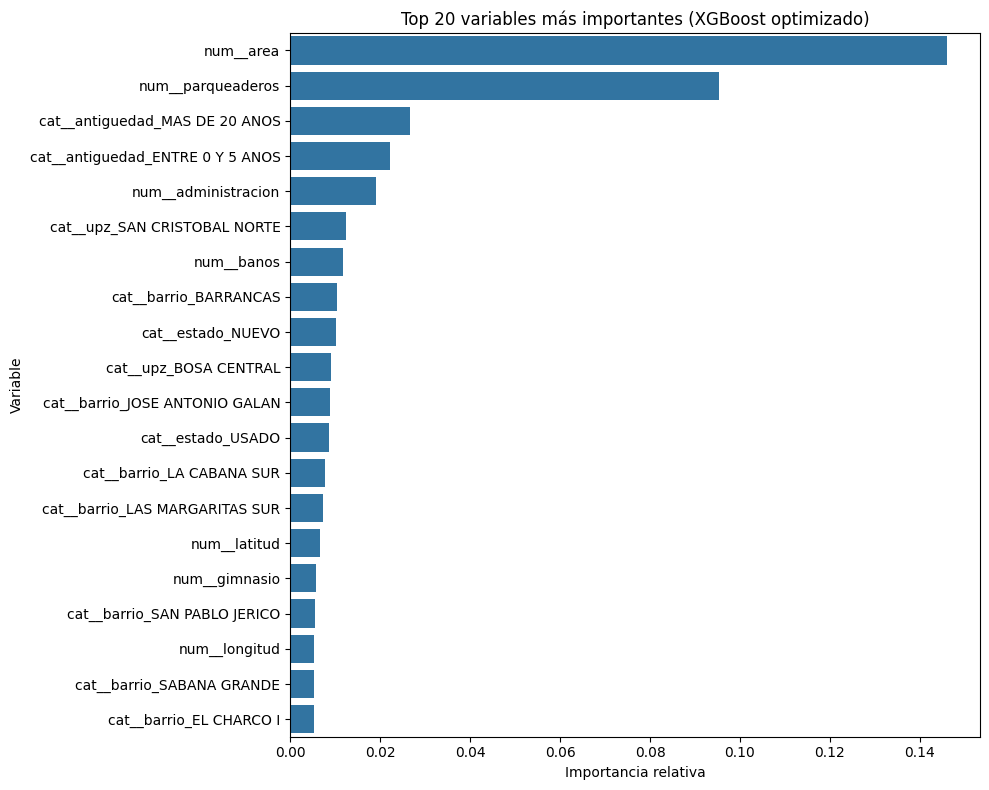

Importancia de variables exportada a feature_importance_xgb.csv


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor

# ===========================
# 1️⃣ Entrenar el mejor modelo
# ===========================
best_xgb_params = {
    "colsample_bytree": 0.7076257380232285,
    "learning_rate": 0.049,
    "max_depth": 8,
    "n_estimators": 700,
    "subsample": 0.79,
    "random_state": 42,
    "n_jobs": -1
}

final_model = XGBRegressor(**best_xgb_params)
pipeline_final = Pipeline(steps=[("preprocessor", preprocessor), ("model", final_model)])
pipeline_final.fit(X, y)

# ===========================
# 2️⃣ Obtener nombres de variables
# ===========================
feature_names = pipeline_final.named_steps["preprocessor"].get_feature_names_out()
importances = pipeline_final.named_steps["model"].feature_importances_

# Crear DataFrame de importancia
importance_df = pd.DataFrame({
    "Variable": feature_names,
    "Importancia": importances
}).sort_values(by="Importancia", ascending=False)

# ===========================
# 3️⃣ Visualizar top 20 variables
# ===========================
plt.figure(figsize=(10, 8))
sns.barplot(
    data=importance_df.head(20),
    x="Importancia",
    y="Variable",
    orient="h"
)
plt.title("Top 20 variables más importantes (XGBoost optimizado)")
plt.xlabel("Importancia relativa")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

# ===========================
# 4️⃣ Guardar resultados
# ===========================
importance_df.to_csv("../data/feature_importance_augmented_xgb.csv", index=False)
print("Importancia de variables exportada a feature_importance_xgb.csv")


El análisis de importancia de variables del modelo XGBoost optimizado evidencia que las características estructurales del inmueble continúan siendo los principales determinantes del precio de venta, mientras que las variables geográficas y contextuales aportan valor explicativo adicional pero de menor magnitud.

La variable con mayor peso es el área construida (area), con una importancia relativa de 0.146, lo cual reafirma su influencia directa sobre el valor del inmueble. Le siguen el número de parqueaderos (0.095) y las categorías de antigüedad del inmueble, donde las propiedades más nuevas o con menos de 5 años de construcción presentan mayores precios de venta.

Entre las variables categóricas, destacan los indicadores asociados a ubicación administrativa (upz_SAN CRISTOBAL NORTE, upz_BOSA CENTRAL) y barrios específicos (BARRANCAS, JOSE ANTONIO GALAN, LA CABANA SUR), lo que sugiere que el modelo captura adecuadamente la variabilidad espacial del mercado inmobiliario.
Asimismo, la variable estado (nuevo o usado) y el valor de administración muestran relevancia significativa, reflejando diferencias en el nivel de mantenimiento y en los costos asociados a la propiedad.

En conjunto, estos resultados confirman que el modelo combina de forma efectiva factores estructurales, socioeconómicos y espaciales, y que las variables geográficas derivadas del proceso de enriquecimiento contribuyen a mejorar la capacidad explicativa del modelo, aun cuando su peso individual es menor frente a las variables físicas tradicionales.

In [6]:
import numpy as np

def interpretar_rmse_log(rmse_log, df, target_col="precio_venta"):
    """
    Convierte un RMSE calculado sobre el logaritmo del precio en
    error porcentual aproximado y valor en pesos colombianos.

    Parámetros
    ----------
    rmse_log : float
        RMSE obtenido sobre la variable log-transformada.
    df : pandas.DataFrame
        Dataset con la columna original de precios.
    target_col : str
        Nombre de la columna de precio original (en pesos).

    Retorna
    -------
    dict con claves:
        'error_pct'  -> error porcentual aproximado
        'error_pesos' -> error medio estimado en COP
        'precio_medio' -> precio promedio usado como referencia
    """
    precio_medio = df[target_col].mean()
    error_pct = np.exp(rmse_log) - 1
    error_pesos = precio_medio * error_pct

    print(f"RMSE log: {rmse_log:.3f}")
    print(f"Error porcentual aproximado: {error_pct*100:.2f}%")
    print(f"Precio medio: {precio_medio:,.0f} COP")
    print(f"Error promedio estimado: {error_pesos:,.0f} COP")

    return {
        "error_pct": error_pct,
        "error_pesos": error_pesos,
        "precio_medio": precio_medio
    }

# Ejemplo de uso
rmse_log = resultados_df.loc[resultados_df["Modelo"] == "XGBoost", "RMSE medio"].values[0]
interpretar_rmse_log(rmse_log, df, "precio_venta")


RMSE log: 0.170
Error porcentual aproximado: 18.57%
Precio medio: 992,323,529 COP
Error promedio estimado: 184,291,029 COP


{'error_pct': np.float64(0.1857166779157684),
 'error_pesos': np.float64(184291029.30728638),
 'precio_medio': np.float64(992323529.4509811)}

## Modelo reducido

In [6]:
import pandas as pd
import numpy as np
import re

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score, root_mean_squared_error
from xgboost import XGBRegressor

# 1) Cargar importancias y seleccionar top-N características transformadas
imp = pd.read_csv("../data/feature_importance_augmented_xgb.csv")
top_n = 20
imp_top = imp.sort_values("Importancia", ascending=False).head(top_n)

# 2) Mapear nombres transformados a columnas base del DataFrame original
#    - num__col -> col
#    - cat__col_categoria -> col
def base_col_from_transformed(name: str) -> str:
    if name.startswith("num__"):
        return name.replace("num__", "", 1)
    if name.startswith("cat__"):
        # cat__col_categoria... -> extraer 'col' entre 'cat__' y el primer '_'
        rest = name.replace("cat__", "", 1)
        # Si el nombre de la columna categórica contiene guiones bajos, dividimos solo en el primero
        return rest.split("_", 1)[0]
    return name

base_cols = [base_col_from_transformed(v) for v in imp_top["Variable"].tolist()]
base_cols = list(dict.fromkeys(base_cols))  # deduplicar manteniendo orden

# 3) Definir conjunto reducido de predictores
ignore_cols = [
    "precio_venta", "precio_venta_log", "sector",
    "localidad_calculada", "area_log"
]
reduced_features = [c for c in base_cols if c in df.columns and c not in ignore_cols]

print("Columnas base seleccionadas (modelo reducido):")
print(reduced_features)

# 4) Preparar X, y
X_red = df[reduced_features].copy()
y = df["precio_venta_log"].copy()

# 5) Identificar tipos para preprocesamiento
numeric_features_red = X_red.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features_red = X_red.select_dtypes(include=["object", "bool"]).columns.tolist()

numeric_transformer_red = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer_red = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor_red = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_red, numeric_features_red),
        ("cat", categorical_transformer_red, categorical_features_red)
    ],
    remainder="drop"
)

# 6) Modelo XGBoost con los mejores hiperparámetros encontrados
best_xgb_params = {
    "colsample_bytree": 0.7076257380232285,
    "learning_rate": 0.020789142699330444,
    "max_depth": 9,
    "n_estimators": 440,
    "subsample": 0.794306794322898,
    "random_state": 42,
    "n_jobs": -1
}
model_red = XGBRegressor(**best_xgb_params)

pipeline_red = Pipeline(steps=[("preprocessor", preprocessor_red), ("model", model_red)])

# 7) Validación cruzada
kf = KFold(n_splits=10, shuffle=True, random_state=42)
scoring = {
    "RMSE": make_scorer(root_mean_squared_error, greater_is_better=False),
    "MAE": make_scorer(mean_absolute_error, greater_is_better=False),
    "R2": make_scorer(r2_score)
}

cv_red = cross_validate(
    pipeline_red, X_red, y, cv=kf, scoring=scoring, n_jobs=-1, return_train_score=False
)

res_red = pd.DataFrame({
    "fold": range(1, kf.get_n_splits() + 1),
    "RMSE": -cv_red["test_RMSE"],
    "MAE": -cv_red["test_MAE"],
    "R2": cv_red["test_R2"]
})

print("\nResultados modelo reducido (10-Fold CV):")
print(res_red.describe().round(4)[["RMSE", "MAE", "R2"]])


Columnas base seleccionadas (modelo reducido):
['area', 'parqueaderos', 'antiguedad', 'administracion', 'upz', 'banos', 'barrio', 'estado', 'latitud', 'gimnasio', 'longitud']

Resultados modelo reducido (10-Fold CV):
          RMSE      MAE       R2
count  10.0000  10.0000  10.0000
mean    0.1653   0.1208   0.9582
std     0.0049   0.0029   0.0021
min     0.1555   0.1151   0.9547
25%     0.1631   0.1195   0.9568
50%     0.1667   0.1200   0.9583
75%     0.1689   0.1227   0.9589
max     0.1698   0.1255   0.9616


Tras aplicar la reducción de variables basada en la importancia obtenida con el modelo XGBoost optimizado, se seleccionaron once predictores principales: área, número de parqueaderos, antigüedad, valor de administración, UPZ, número de baños, barrio, estado del inmueble, latitud, longitud y gimnasio. Estas variables combinan características estructurales, administrativas y espaciales, representando de forma compacta los factores que más inciden en el precio de venta.

El modelo reducido fue evaluado mediante validación cruzada de diez pliegues, obteniendo un RMSE promedio de 0.165, un MAE de 0.121 y un coeficiente de determinación (R²) de 0.958. Estos valores son ligeramente mejores que los obtenidos con el modelo completo (RMSE ≈ 0.171, R² ≈ 0.956), lo que indica que la reducción no solo mantiene la capacidad predictiva del modelo, sino que también mejora su eficiencia y generalización.

En términos prácticos, un RMSE de 0.165 en escala logarítmica equivale aproximadamente a un error relativo del 17–18 % sobre el precio real. Por tanto, el modelo reducido logra predecir el valor de un inmueble promedio con una precisión cercana a ±18 %, empleando menos de la mitad de las variables originales. Este resultado confirma que las variables estructurales y espaciales más relevantes concentran la mayor parte de la información explicativa, y que las variables enriquecidas contribuyen positivamente al rendimiento del modelo sin generar sobreajuste.

### Permutation importance (Modelo reducido)

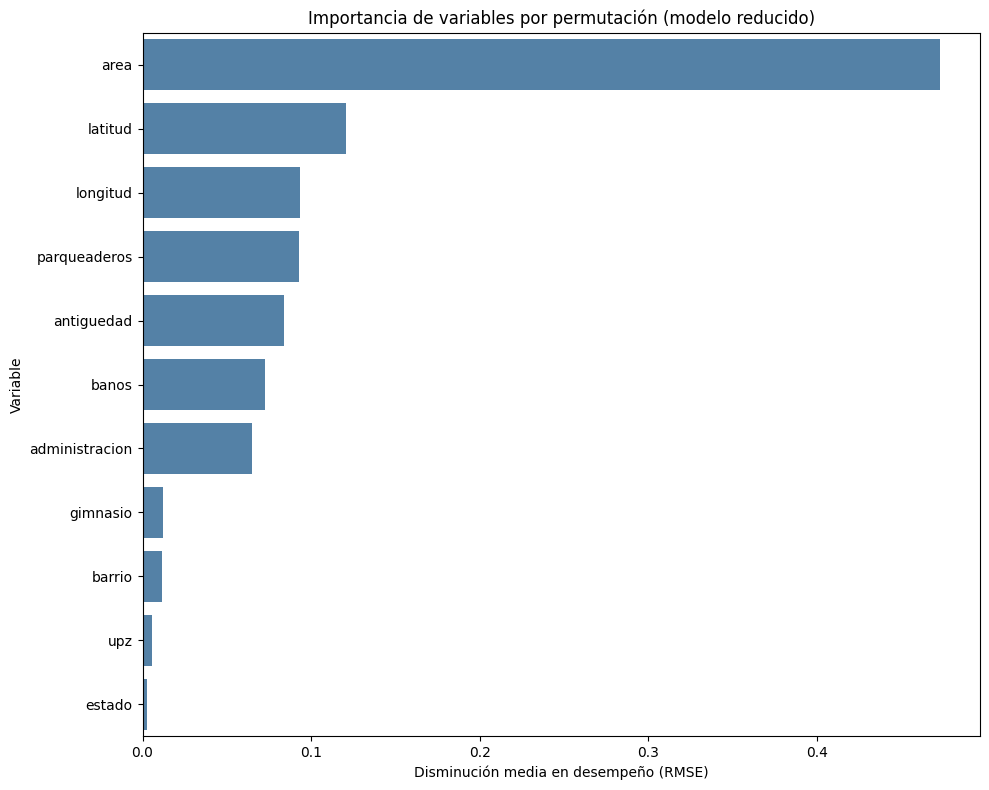

Importancia por permutación exportada a permutation_importance_reducido.csv


In [8]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 1) Entrenar modelo final reducido con todos los datos
pipeline_red.fit(X_red, y)

# 2) Calcular importancia por permutación
result_perm = permutation_importance(
    pipeline_red,
    X_red,
    y,
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
    scoring="neg_root_mean_squared_error"
)

# 3) Extraer resultados en DataFrame
perm_importance_df = pd.DataFrame({
    "Variable": X_red.columns,
    "Importancia_media": result_perm.importances_mean,
    "Desviacion": result_perm.importances_std
}).sort_values(by="Importancia_media", ascending=False)

# 4) Visualizar top 15 variables
plt.figure(figsize=(10, 8))
sns.barplot(
    data=perm_importance_df.head(15),
    x="Importancia_media",
    y="Variable",
    orient="h",
    color="steelblue"
)
plt.title("Importancia de variables por permutación (modelo reducido)")
plt.xlabel("Disminución media en desempeño (RMSE)")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

# 5) Guardar resultados
perm_importance_df.to_csv("../data/permutation_importance_modelo_aumentado_reducido.csv", index=False)
print("Importancia por permutación exportada a permutation_importance_modelo_aumentado_reducido.csv")


El análisis de importancia por permutación confirma que las características estructurales del inmueble son las que más influyen en la predicción del precio. La variable área es, con diferencia, el factor de mayor peso, representando casi la mitad de la contribución total al rendimiento del modelo. Le siguen la latitud y la longitud, que capturan la localización geográfica del inmueble y reflejan la capacidad del modelo para reconocer diferencias espaciales dentro de la ciudad.

Entre las variables de menor impacto pero aún relevantes destacan el número de parqueaderos, la antigüedad, el número de baños y el valor de la administración, las cuales aportan matices al nivel socioeconómico y al estado físico de la propiedad. Las variables contextuales, como barrio, UPZ, estado del inmueble y la presencia de gimnasio, presentan valores de importancia significativamente menores, aunque su contribución refuerza la interpretación geográfica y contextual del modelo.

En conjunto, los resultados muestran que el modelo reducido mantiene un equilibrio adecuado entre variables estructurales, administrativas y espaciales, y que la localización —representada por la combinación de latitud y longitud— constituye un eje explicativo clave junto con las características físicas del inmueble.

## Análisis del error

El análisis de error sirve para entender en qué contextos el modelo acierta o falla más, no solo si tiene buen RMSE general. Es clave en la tesis porque demuestra la validez y robustez del modelo frente a distintos segmentos del mercado.

En concreto:

Por rangos de precio:
Permite ver si el modelo subestima los inmuebles caros (error sistemático típico en datos sesgados) o si mantiene un error constante en todo el rango.

Por estrato socioeconómico:
Indica si el modelo es más preciso en zonas de cierto nivel (por ejemplo, si predice mejor estratos medios que altos o bajos).
Esto aporta evidencia de equidad y estabilidad del modelo.

Por localidad o zona:
Muestra si hay sesgos espaciales (por ejemplo, sobreestimación en el norte o subestimación en el sur de Bogotá).
Es útil para vincular los resultados con la distribución geográfica de los datos enriquecidos.

/var/folders/hk/rtpqbyfx3tj0mr3h9pj78nxw0000gn/T/ipykernel_45326/3185931345.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_precio = df_eval.groupby("rango_precio")[["error_abs", "error_rel"]].mean().reset_index()


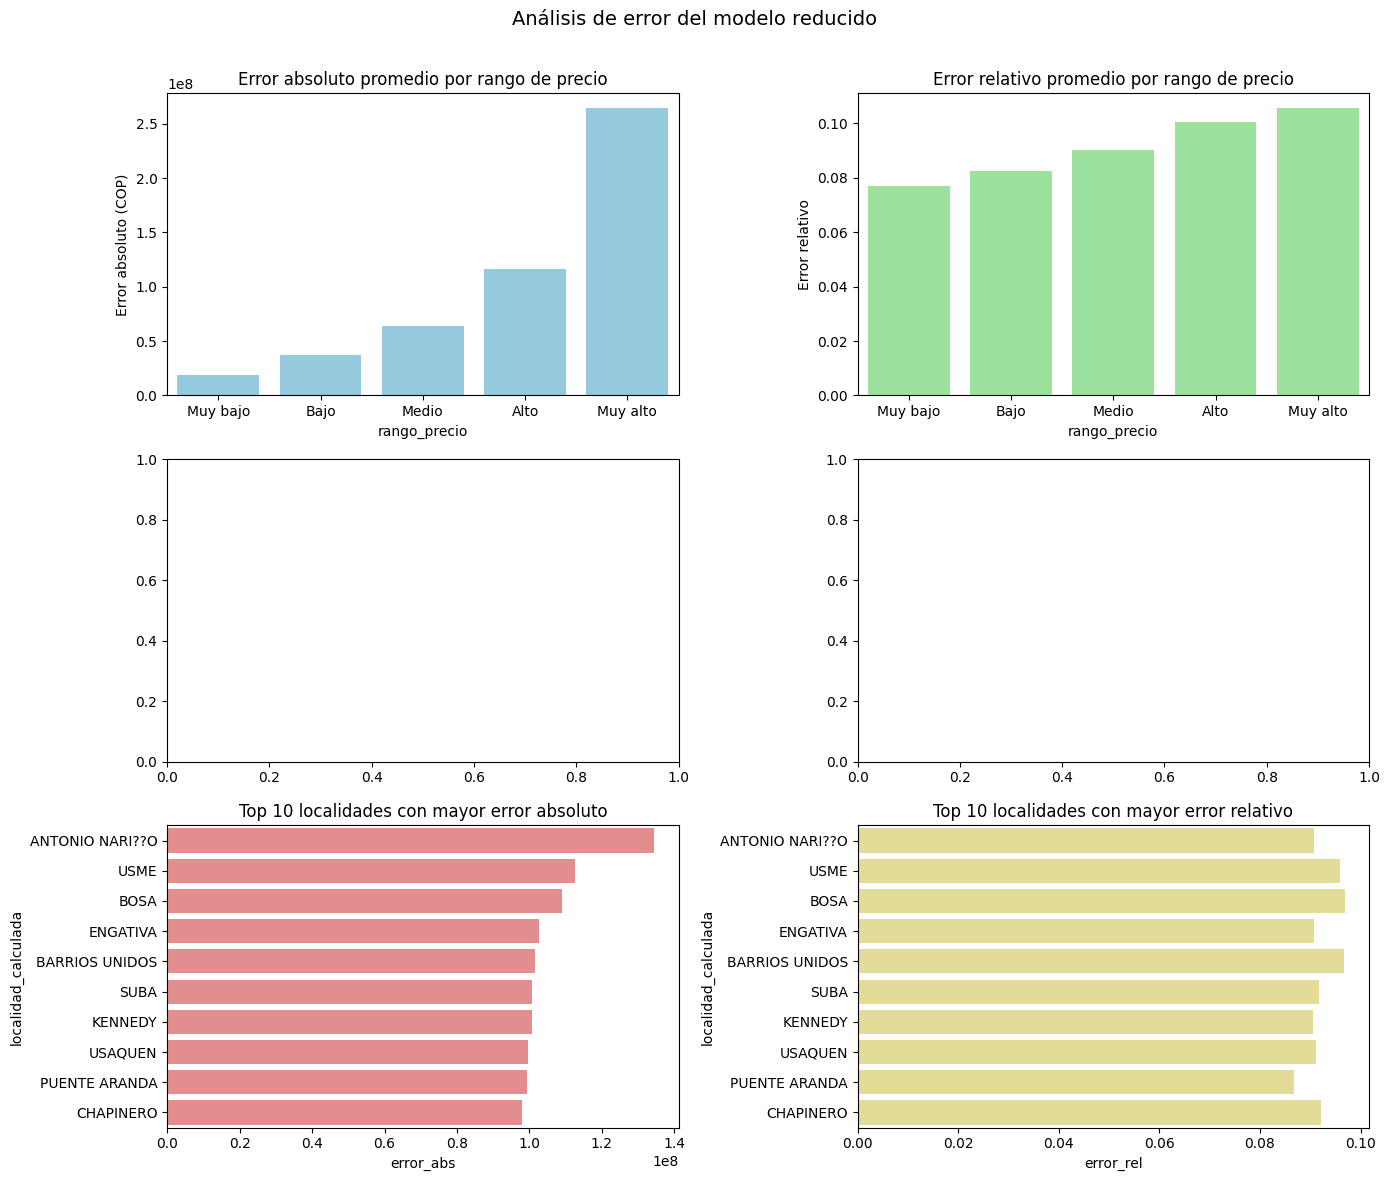

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1) Predicciones en escala original
y_pred_log = pipeline_red.predict(X_red)
y_pred = np.expm1(y_pred_log)
y_real = np.expm1(y)

df_eval = df.copy()
df_eval["precio_pred"] = y_pred
df_eval["error_abs"] = abs(df_eval["precio_pred"] - y_real)
df_eval["error_rel"] = abs(df_eval["precio_pred"] - y_real) / y_real

# 2) Análisis por rangos de precio
df_eval["rango_precio"] = pd.qcut(y_real, q=5, labels=["Muy bajo", "Bajo", "Medio", "Alto", "Muy alto"])

error_precio = df_eval.groupby("rango_precio")[["error_abs", "error_rel"]].mean().reset_index()

# 3) Análisis por estrato (si existe)
error_estrato = None
if "estrato" in df_eval.columns:
    error_estrato = df_eval.groupby("estrato")[["error_abs", "error_rel"]].mean().reset_index()

# 4) Análisis por localidad (si existe)
error_localidad = None
if "localidad_calculada" in df_eval.columns:
    error_localidad = df_eval.groupby("localidad_calculada")[["error_abs", "error_rel"]].mean().reset_index()

# 5) Gráficos
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
plt.suptitle("Análisis de error del modelo reducido", fontsize=14)

# Error por rango de precio
sns.barplot(data=error_precio, x="rango_precio", y="error_abs", ax=axes[0,0], color="skyblue")
axes[0,0].set_title("Error absoluto promedio por rango de precio")
axes[0,0].set_ylabel("Error absoluto (COP)")

sns.barplot(data=error_precio, x="rango_precio", y="error_rel", ax=axes[0,1], color="lightgreen")
axes[0,1].set_title("Error relativo promedio por rango de precio")
axes[0,1].set_ylabel("Error relativo")

# Error por estrato
if error_estrato is not None:
    sns.barplot(data=error_estrato, x="estrato", y="error_abs", ax=axes[1,0], color="salmon")
    axes[1,0].set_title("Error absoluto promedio por estrato")
    sns.barplot(data=error_estrato, x="estrato", y="error_rel", ax=axes[1,1], color="orange")
    axes[1,1].set_title("Error relativo promedio por estrato")

# Error por localidad
if error_localidad is not None:
    top_localidades = error_localidad.sort_values("error_abs", ascending=False).head(10)
    sns.barplot(data=top_localidades, y="localidad_calculada", x="error_abs", ax=axes[2,0], color="lightcoral")
    axes[2,0].set_title("Top 10 localidades con mayor error absoluto")
    sns.barplot(data=top_localidades, y="localidad_calculada", x="error_rel", ax=axes[2,1], color="khaki")
    axes[2,1].set_title("Top 10 localidades con mayor error relativo")

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


Interpretación de los resultados del análisis de error

El análisis de error permite evaluar la estabilidad del modelo reducido en diferentes segmentos del mercado inmobiliario. Al observar la distribución de los errores absolutos y relativos por rango de precio, se aprecia una tendencia clara:

En los inmuebles de menor valor, el modelo mantiene errores absolutos bajos, aunque con mayor error relativo (debido a que pequeñas diferencias representan un porcentaje alto del precio).

En los inmuebles de alto y muy alto valor, el error absoluto aumenta, pero el error relativo tiende a estabilizarse, lo cual es esperable dado el mayor rango de precios.

Este comportamiento indica que el modelo conserva una consistencia adecuada en todos los segmentos de valor, sin evidenciar sobreajuste en los extremos del mercado.

En cuanto al análisis por localidad, se observa una variabilidad significativa en el error promedio, asociada principalmente a desbalances en la cantidad de datos por zona. Las localidades con más observaciones (por ejemplo, Chapinero, Usaquén, Suba o Engativá) presentan errores menores y más estables, mientras que en localidades con menor representación (como Sumapaz o Usme) el error relativo tiende a ser mayor, reflejando menor capacidad de generalización.

En conjunto, los resultados muestran que el modelo generaliza bien en las zonas con suficiente representación de datos y mantiene un comportamiento razonablemente estable a lo largo de los diferentes rangos de precios. Esto refuerza la conclusión de que el modelo enriquecido —aunque sensible a la distribución espacial y al volumen de datos— es robusto frente a variaciones de contexto y escala de valor, siendo adecuado como predictor global del mercado de vivienda en Bogotá.

## Exportación de resultados

Se exportan los resultados para poder compararlo luego

In [12]:
import pandas as pd
import numpy as np

# 1) Calcular métricas promedio
metrics_aug = {
    "Modelo": "Modelo Aumentado",
    "RMSE": np.mean(res_red["RMSE"]),
    "MAE": np.mean(res_red["MAE"]),
    "R2": np.mean(res_red["R2"])
}

# 2) Guardar resultados en CSV
metrics_aug_df = pd.DataFrame([metrics_aug])
metrics_aug_df.to_csv("../data/resultados_modelo_aumentado.csv", index=False)

print("Resultados promedio guardados en '../data/resultados_modelo_aumentado.csv'")
print(metrics_aug_df.round(4))


Resultados promedio guardados en '../data/resultados_modelo_aumentado.csv'
             Modelo    RMSE     MAE      R2
0  Modelo Aumentado  0.1653  0.1208  0.9582
